# Chapter 5. 정규선형모델

## 2. 분산분석

* 종속변수: 매상
* 독립변수: 날씨(흐림, 비, 맑음)


#### "날씨에 따라 매상이 변화한다고 말할 수 있는지 확인해보기!"

-----
**분산분석**(**AN**alysis **O**f **VA**riance)

- 세 개 이상의 수준 간의 평균값의 차이가 있는지 검정
- 모집단이 정규분포를 따르는 데이터에 적용
- F비  
    효과의 분산크기 / 오차의 분산크기  
    = 날씨에 따른 매상변동 / 날씨로 설명할 수 없는 매상변동   
    = 군간변동/군내변동
- F비가 크면 오차에 비해 효과의 영향이 크다

- F분포
    - 모집단분포가 등분산 정규분포일 때, F비의 표본분포
    - F 분포의 누적분포함수를 사용해서 p값 계산
    - p값이 0.05이하이면 귀무가설 기각


### 5.2.8. 분석준비

In [1]:
# 수치계산에 필요한 라이브러리
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 그래프를 그리기 위한 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 선형모델을 추정하는 라이브러리(경고가 나올 수 있습니다)
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 표시 자릿수 지정
%precision 3
# 그래프를 주피터 노트북에 그리기 위한 설정
%matplotlib inline

### 5.2.9 데이터의 작성과 표시

In [2]:
# 샘플 데이터 생성
weather = [
    "cloudy","cloudy",
    "rainy","rainy",
    "sunny","sunny"
]
beer = [6,8,2,4,10,12]

# 데이터프레임으로 결합
weather_beer = pd.DataFrame({
    "beer"   : beer,
    "weather": weather
})
print(weather_beer)

   beer weather
0     6  cloudy
1     8  cloudy
2     2   rainy
3     4   rainy
4    10   sunny
5    12   sunny


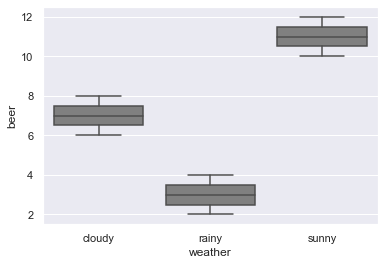

In [3]:
# BoxPlot
sns.boxplot(x = "weather",y = "beer",
            data = weather_beer, color='gray')

비오는 날은 매상이 적고, 맑은 날은 매상이 많음

In [4]:
# 각 데이터의 평균값
print(weather_beer.groupby("weather").mean())

         beer
weather      
cloudy      7
rainy       3
sunny      11


### 5.2.10 분산분석(1): 군간 제곱과 군내 제곱 계산

In [5]:
# 날씨에 의한 영향
effect = [7,7,3,3,11,11]

In [6]:
# 군간 제곱합
mu_effect = np.mean(effect)
squares_model = np.sum((effect - mu_effect) ** 2 )
squares_model

64.0

In [7]:
# 오차 = 원래 데이터 - 효과
resid = weather_beer.beer - effect
resid

0   -1
1    1
2   -1
3    1
4   -1
5    1
Name: beer, dtype: int64

In [8]:
# 군내 제곱합
squares_resid = np.sum(resid ** 2)
squares_resid

6

### 5.2.11 분산분석(2): 군간 분산과 군내 분산 계산

In [9]:
df_model = 2 # 군간변동의 자유도
df_resid = 3 # 군내변동의 자유도

In [10]:
# 군간 평균제곱(분산)
variance_model = squares_model / df_model
variance_model

32.0

In [11]:
# 군내 평균제곱(분산)
variance_resid = squares_resid / df_resid
variance_resid

2.0

### 5.2.12 분산분석(3): p값 계산

In [12]:
# F비 = 군간분산 / 군내분산
f_ratio = variance_model / variance_resid
f_ratio

16.0

In [13]:
# p값
1 - sp.stats.f.cdf(x=f_ratio,dfn=df_model,dfd=df_resid)

0.02509457330439091

[결론]  
p값이 0.05보다 작으므로, 날씨에 의해 매상이 유의미하게 변한다고 판단할 수 있음

### 5.2.15 statsmodels를 이용한 분산분석

In [14]:
# 정규 선형 모델의 구축
anova_model = smf.ols("beer ~ weather", 
                      data = weather_beer).fit()

In [15]:
# 분산 분석 결과
print(sm.stats.anova_lm(anova_model, typ=2))

          sum_sq   df     F    PR(>F)
weather     64.0  2.0  16.0  0.025095
Residual     6.0  3.0   NaN       NaN


* sum_sq : 편차제곱합
* df: 자유도
* F : F비
* PR : p값


p값(0.025095)이 0.05보다 작으므로, 날씨에 의해 매상이 유의미하게 변한다고 판단할 수 있음

### 5.2.17 모델의 계수 해석

In [16]:
anova_model.params

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

***7.0 - 4.0 x 비 + 4.0 x 맑음***

* 흐린 날 매상 평균: 7
* 비오는 날 매상 평균: 3
* 맑은 날 매상 평균: 11


### 5.2.18 모델을 사용해서 오차와 효과 분리하기

In [17]:
#훈련데이터 적용 결과
fitted = anova_model.fittedvalues
fitted

0     7.0
1     7.0
2     3.0
3     3.0
4    11.0
5    11.0
dtype: float64

In [18]:
# 잔차값
anova_model.resid

0   -1.0
1    1.0
2   -1.0
3    1.0
4   -1.0
5    1.0
dtype: float64

### 5.2.19 회귀모델의 분산분석

* 맥주와 기온관계의 회귀모델을 분산분석으로 검정하기

In [19]:
# 데이터 읽어 들이기
beer = pd.read_csv("5-1-1-beer.csv")

# 모델 추정
lm_model = smf.ols(formula = "beer ~ temperature", 
                   data = beer).fit()

1) 군간변동
 - 독립변수가 연속형인 데이터에서는 **모델의 자유도** 라는 용어 사용  
 - **모델의 자유도** : 추정된 파라미터 수 - 1
 - 추정된 파라미터 수: 2개(절편과 기울기) 
 
2) 군내변동
 - 독립변수가 연속형인 데이터에서는 **잔차의 자유도** 라는 용어 사용
 - **잔차의 자유도** = 샘플사이즈 - 추정된 파라미터 수
 - 샘플사이즈 : 30개

In [20]:
df_lm_model = 1  # 모델의 자유도
df_lm_resid = 28 # 잔차의 자유도

In [21]:
# 모델을 적용한 값
lm_effect = lm_model.fittedvalues
# 잔차
lm_resid = lm_model.resid
# 기온의 효과와 크기
mu = np.mean(lm_effect)
squares_lm_model = np.sum((lm_effect - mu) ** 2)
variance_lm_model = squares_lm_model / df_lm_model
# 잔차의 크기
squares_lm_resid = np.sum((lm_resid) ** 2)
variance_lm_resid = squares_lm_resid / df_lm_resid
# F비
f_value_lm = variance_lm_model / variance_lm_resid
f_value_lm

28.44698368850463

In [22]:
# p값이 거의 0이 되어버리림
1 - sp.stats.f.cdf(
    x=f_value_lm,dfn=df_lm_model,dfd=df_lm_resid)

1.1148907825053733e-05

In [23]:
# 분산분석표 출력하여 f비 확인
print(sm.stats.anova_lm(lm_model, typ=2))

                  sum_sq    df          F    PR(>F)
temperature  1651.532489   1.0  28.446984  0.000011
Residual     1625.582178  28.0        NaN       NaN


In [24]:
# Sumamry
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           1.11e-05
Time:                        15:32:09   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* F-statistic: F비
* Prob (F-statistic): 분산분석의 p

## [정리]

### 분산분석(ANOVA)

- 두 개 이상의 집단에서 그룹간 차이를 그룹 내 변동에 비교해여 살펴보는 데이터 분석 방법

- F검정을 하여 얻어진 p값을 유의수준과 비교하여 검정

  

1. 모델링

   anova_model = smf.**ols**("beer ~ weather", data = weather_beer).fit()
   
   

2. 분산분석  

   sm.stats.**anova_lm**(anova_model, **typ=2**)